# Introduction

This is the analysis of gut intestinal stem cell data as presented in Böttcher et al. We use in total **75,012** cells from **14 samples** in **6 conditions** (2 replicates in each mutant, 3 replicates in each control and 1 sample FVR only controls):

* Control (whole crypt)
* Control (FVR enriched)
* Control (FVR only)
* Mutant (Fltp deficient, whole crypt)
* Mutant (Fltp deficient, FVR enriched)
* Control (High fat diet project)

In this notebook, we load the raw data and filter them according to the thresholds defined by CellRanger.

We filter cells by

* number of reads
* number of detected genes
* fraction of mitochondrial reads (< 10%) 


## Tasks in this notebook

In order to keep the notebook structure short and well-arranged, we have split the gut intestinal stem cell analysis into several parts:

1. Basic pre-processing and cell filtering
2. Preparation of Batch effect correction
3. Data analysis with Graph abstraction

This notebook covers **part 1**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
from matplotlib import rcParams
import scipy as sci


sc.settings.verbosity = 3
sc.logging.print_version_and_date()

Running Scanpy 1.3.1 on 2021-01-22 09:55.


In [2]:
sc.settings.writedir='./../data/'

In [3]:
def qc_metrics(adata):
    
    # mean expression per gene
    adata.var["mean"] = adata.X.mean(axis=0).T
    # fraction of 0s per genes
    adata.var["frac_zeros"] = (adata.X.shape[0] - (adata.X > 0).sum(axis=0).T) / adata.X.shape[0]
    
    # for each cell compute fraction of counts in mito genes vs. all genes
    mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
    mt_gene_index = np.where(mito_genes)[0]
    adata.obs['percent_mito'] = adata[:, mt_gene_index].X.sum(axis=1) / adata.X.sum(axis=1)
    # for each cell compute fraction of counts in ribosomal genes vs. all genes
    ribo_genes = [name for name in adata.var_names if name.startswith('Rp')]
    ribo_gene_index = np.where(ribo_genes)[0]
    adata.obs['percent_ribo'] = adata[:, ribo_gene_index].X.sum(axis=1) / adata.X.sum(axis=1)

    # total counts and genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1
    print(len(adata.obs_names))
    
    return(adata)

In [7]:
def cell_filter(adata, countmin):
    #filter cells with > countmin number of counts and >1000 genes. Countmin is defined based on the CellRanger output. 
    
    # get cell barcode indices
    res_cells = sc.pp.filter_cells(adata.X,min_counts=countmin,copy=True)
    res_genes = sc.pp.filter_cells(adata.X,min_genes=1000,copy=True)
    res_all = np.array([any(tup) for tup in zip(res_cells[0], res_genes[0])])
    
    # filter
    adata_filt=adata.copy()[res_all,:]
    print(adata_filt.n_obs)
    return(adata_filt)

# WT, FVR and mutant mice

In [9]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Control_1 = './../filtered_data/Control_1/matrix.mtx'
filename_genes_Control_1 = './../filtered_data/Control_1/genes.tsv'
filename_barcodes_Control_1 = './../filtered_data/Control_1/barcodes.tsv'

adata_Control_1 = sc.read(filename_data_Control_1, cache=True).transpose()
adata_Control_1.var_names = np.genfromtxt(filename_genes_Control_1, dtype=str)[:, 1]
adata_Control_1.obs_names = np.genfromtxt(filename_barcodes_Control_1, dtype=str)

# raw data (all barcodes)
filename_data_Control_1 = './../raw_data/Control_1/matrix.mtx'
filename_genes_Control_1 = './../raw_data/Control_1/genes.tsv'
filename_barcodes_Control_1 = './../raw_data/Control_1/barcodes.tsv'

adata_Control_1_raw = sc.read(filename_data_Control_1, cache=True).transpose()
adata_Control_1_raw.var_names = np.genfromtxt(filename_genes_Control_1, dtype=str)[:, 1]
adata_Control_1_raw.obs_names = np.genfromtxt(filename_barcodes_Control_1, dtype=str)

... reading from cache file ./cache/filtered_data-Control_1-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... reading from cache file ./cache/raw_data-Control_1-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
adata_Control_1 = qc_metrics(adata_Control_1)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Control_1.obs['n_counts'])
del adata_Control_1
adata_Control_1 = cell_filter(adata_Control_1_raw, countmin)
del adata_Control_1_raw

3440
filtered out 733840 cells that have less than 6604.0 counts
filtered out 733248 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
4047


In [11]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Control_2 = './../filtered_data/Mutant_1/matrix.mtx'   #####two samples were exchanged 
filename_genes_Control_2 = './../filtered_data/Mutant_1/genes.tsv'
filename_barcodes_Control_2 = './../filtered_data/Mutant_1/barcodes.tsv'

adata_Control_2 = sc.read(filename_data_Control_2, cache=True).transpose()
adata_Control_2.var_names = np.genfromtxt(filename_genes_Control_2, dtype=str)[:, 1]
adata_Control_2.obs_names = np.genfromtxt(filename_barcodes_Control_2, dtype=str)


# raw data (all barcodes)
filename_data_Control_2 = './../raw_data/Mutant_1/matrix.mtx'   #####two samples were exchanged 
filename_genes_Control_2 = './../raw_data/Mutant_1/genes.tsv'
filename_barcodes_Control_2 = './../raw_data/Mutant_1/barcodes.tsv'

adata_Control_2_raw = sc.read(filename_data_Control_2).transpose()
adata_Control_2_raw.var_names = np.genfromtxt(filename_genes_Control_2, dtype=str)[:, 1]
adata_Control_2_raw.obs_names = np.genfromtxt(filename_barcodes_Control_2, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
adata_Control_2 = qc_metrics(adata_Control_2)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Control_2.obs['n_counts'])
del adata_Control_2
adata_Control_2 = cell_filter(adata_Control_2_raw, countmin)
del adata_Control_2_raw

2940
filtered out 734340 cells that have less than 5691.0 counts
filtered out 733749 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
3542


In [13]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Control_3_FVR = './../filtered_data/Control_3_FVR/matrix.mtx'
filename_genes_Control_3_FVR = './../filtered_data/Control_3_FVR/genes.tsv'
filename_barcodes_Control_3_FVR = './../filtered_data/Control_3_FVR/barcodes.tsv'

adata_Control_3_FVR = sc.read(filename_data_Control_3_FVR, cache=True).transpose()
adata_Control_3_FVR.var_names = np.genfromtxt(filename_genes_Control_3_FVR, dtype=str)[:, 1]
adata_Control_3_FVR.obs_names = np.genfromtxt(filename_barcodes_Control_3_FVR, dtype=str)

# raw data (all barcodes)
filename_data_Control_3_FVR = './../raw_data/Control_3_FVR/matrix.mtx'
filename_genes_Control_3_FVR = './../raw_data/Control_3_FVR/genes.tsv'
filename_barcodes_Control_3_FVR = './../raw_data/Control_3_FVR/barcodes.tsv'

adata_Control_3_FVR_raw = sc.read(filename_data_Control_3_FVR, cache=True).transpose()
adata_Control_3_FVR_raw.var_names = np.genfromtxt(filename_genes_Control_3_FVR, dtype=str)[:, 1]
adata_Control_3_FVR_raw.obs_names = np.genfromtxt(filename_barcodes_Control_3_FVR, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
adata_Control_3_FVR = qc_metrics(adata_Control_3_FVR)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Control_3_FVR.obs['n_counts'])
del adata_Control_3_FVR
adata_Control_3_FVR = cell_filter(adata_Control_3_FVR_raw, countmin)
del adata_Control_3_FVR_raw

3766
filtered out 733514 cells that have less than 10409.0 counts
filtered out 732917 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
4416


In [15]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Control_4_FVR = './../filtered_data/Mutant_3_FVR/matrix.mtx'  #####two samples were exchanged 
filename_genes_Control_4_FVR = './../filtered_data/Mutant_3_FVR/genes.tsv'
filename_barcodes_Control_4_FVR = './../filtered_data/Mutant_3_FVR/barcodes.tsv'

adata_Control_4_FVR = sc.read(filename_data_Control_4_FVR, cache=True).transpose()
adata_Control_4_FVR.var_names = np.genfromtxt(filename_genes_Control_4_FVR, dtype=str)[:, 1]
adata_Control_4_FVR.obs_names = np.genfromtxt(filename_barcodes_Control_4_FVR, dtype=str)

# raw data (all barcodes)
filename_data_Control_4_FVR = './../raw_data/Mutant_3_FVR/matrix.mtx'  #####two samples were exchanged 
filename_genes_Control_4_FVR = './../raw_data/Mutant_3_FVR/genes.tsv'
filename_barcodes_Control_4_FVR = './../raw_data//Mutant_3_FVR/barcodes.tsv'

adata_Control_4_FVR_raw = sc.read(filename_data_Control_4_FVR, cache=True).transpose()
adata_Control_4_FVR_raw.var_names = np.genfromtxt(filename_genes_Control_4_FVR, dtype=str)[:, 1]
adata_Control_4_FVR_raw.obs_names = np.genfromtxt(filename_barcodes_Control_4_FVR, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
adata_Control_4_FVR = qc_metrics(adata_Control_4_FVR)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Control_4_FVR.obs['n_counts'])
del adata_Control_4_FVR
adata_Control_4_FVR = cell_filter(adata_Control_4_FVR_raw,countmin)
del adata_Control_4_FVR_raw

4566
filtered out 732714 cells that have less than 8212.0 counts
filtered out 731954 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
5338


In [17]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Mutant_1 = './../filtered_data/Control_2/matrix.mtx' #####two samples were exchanged 
filename_genes_Mutant_1 = './../filtered_data/Control_2/genes.tsv'
filename_barcodes_Mutant_1 = './../filtered_data/Control_2/barcodes.tsv'

adata_Mutant_1 = sc.read(filename_data_Mutant_1, cache=True).transpose()
adata_Mutant_1.var_names = np.genfromtxt(filename_genes_Mutant_1, dtype=str)[:, 1]
adata_Mutant_1.obs_names = np.genfromtxt(filename_barcodes_Mutant_1, dtype=str)

# raw data (all barcodes)
filename_data_Mutant_1 = './../raw_data/Control_2/matrix.mtx' #####two samples were exchanged 
filename_genes_Mutant_1 = './../raw_data/Control_2/genes.tsv'
filename_barcodes_Mutant_1 = './../raw_data/Control_2/barcodes.tsv'

adata_Mutant_1_raw = sc.read(filename_data_Mutant_1, cache=False).transpose()
adata_Mutant_1_raw.var_names = np.genfromtxt(filename_genes_Mutant_1, dtype=str)[:, 1]
adata_Mutant_1_raw.obs_names = np.genfromtxt(filename_barcodes_Mutant_1, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [18]:
### QC and cell filtering
adata_Mutant_1 = qc_metrics(adata_Mutant_1)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Mutant_1.obs['n_counts'])
del adata_Mutant_1
adata_Mutant_1 = cell_filter(adata_Mutant_1_raw, countmin)
del adata_Mutant_1_raw

3386
filtered out 733894 cells that have less than 8673.0 counts
filtered out 733346 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
3949


In [19]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Mutant_2 = './../filtered_data/Mutant_2/matrix.mtx'   
filename_genes_Mutant_2 = './../filtered_data/Mutant_2/genes.tsv'
filename_barcodes_Mutant_2 = './../filtered_data/Mutant_2/barcodes.tsv'

adata_Mutant_2 = sc.read(filename_data_Mutant_2, cache=True).transpose()
adata_Mutant_2.var_names = np.genfromtxt(filename_genes_Mutant_2, dtype=str)[:, 1]
adata_Mutant_2.obs_names = np.genfromtxt(filename_barcodes_Mutant_2, dtype=str)

# raw data (all barcodes)
filename_data_Mutant_2 = './../raw_data/Mutant_2/matrix.mtx'   
filename_genes_Mutant_2 = './../raw_data/Mutant_2/genes.tsv'
filename_barcodes_Mutant_2 = './../raw_data/Mutant_2/barcodes.tsv'

adata_Mutant_2_raw = sc.read(filename_data_Mutant_2, cache=True).transpose()
adata_Mutant_2_raw.var_names = np.genfromtxt(filename_genes_Mutant_2, dtype=str)[:, 1]
adata_Mutant_2_raw.obs_names = np.genfromtxt(filename_barcodes_Mutant_2, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [20]:
### QC and cell filtering
adata_Mutant_2 = qc_metrics(adata_Mutant_2)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Mutant_2.obs['n_counts'])
del adata_Mutant_2
adata_Mutant_2 = cell_filter(adata_Mutant_2_raw, countmin)
del adata_Mutant_2_raw

3611
filtered out 733669 cells that have less than 7461.0 counts
filtered out 733119 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
4167


In [21]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Mutant_3_FVR = './../filtered_data/Control_4_FVR/matrix.mtx'  #####two samples were exchanged 
filename_genes_Mutant_3_FVR = './../filtered_data/Control_4_FVR/genes.tsv'
filename_barcodes_Mutant_3_FVR = './../filtered_data/Control_4_FVR/barcodes.tsv'

adata_Mutant_3_FVR = sc.read(filename_data_Mutant_3_FVR, cache=True).transpose()
adata_Mutant_3_FVR.var_names = np.genfromtxt(filename_genes_Mutant_3_FVR, dtype=str)[:, 1]
adata_Mutant_3_FVR.obs_names = np.genfromtxt(filename_barcodes_Mutant_3_FVR, dtype=str)

# raw data (all barcodes)
filename_data_Mutant_3_FVR = './../raw_data/Control_4_FVR/matrix.mtx'  #####two samples were exchanged 
filename_genes_Mutant_3_FVR = './../raw_data/Control_4_FVR/genes.tsv'
filename_barcodes_Mutant_3_FVR = './../raw_data/Control_4_FVR/barcodes.tsv'

adata_Mutant_3_FVR_raw = sc.read(filename_data_Mutant_3_FVR, cache=True).transpose()
adata_Mutant_3_FVR_raw.var_names = np.genfromtxt(filename_genes_Mutant_3_FVR, dtype=str)[:, 1]
adata_Mutant_3_FVR_raw.obs_names = np.genfromtxt(filename_barcodes_Mutant_3_FVR, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
### QC and cell filtering
adata_Mutant_3_FVR = qc_metrics(adata_Mutant_3_FVR)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Mutant_3_FVR.obs['n_counts'])
del adata_Mutant_3_FVR
adata_Mutant_3_FVR = cell_filter(adata_Mutant_3_FVR_raw,countmin)
del adata_Mutant_3_FVR_raw

3153
filtered out 734127 cells that have less than 11376.0 counts
filtered out 733307 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
3978


In [23]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_Mutant_4_FVR = './../filtered_data/Mutant_4_FVR/matrix.mtx'
filename_genes_Mutant_4_FVR = './../filtered_data/Mutant_4_FVR/genes.tsv'
filename_barcodes_Mutant_4_FVR = './../filtered_data/Mutant_4_FVR/barcodes.tsv'

adata_Mutant_4_FVR = sc.read(filename_data_Mutant_4_FVR, cache=True).transpose()
adata_Mutant_4_FVR.var_names = np.genfromtxt(filename_genes_Mutant_4_FVR, dtype=str)[:, 1]
adata_Mutant_4_FVR.obs_names = np.genfromtxt(filename_barcodes_Mutant_4_FVR, dtype=str)

# raw data (all barcodes)
filename_data_Mutant_4_FVR = './../raw_data/Mutant_4_FVR/matrix.mtx'
filename_genes_Mutant_4_FVR = './../raw_data/Mutant_4_FVR/genes.tsv'
filename_barcodes_Mutant_4_FVR = './../raw_data/Mutant_4_FVR/barcodes.tsv'

adata_Mutant_4_FVR_raw = sc.read(filename_data_Mutant_4_FVR, cache=True).transpose()
adata_Mutant_4_FVR_raw.var_names = np.genfromtxt(filename_genes_Mutant_4_FVR, dtype=str)[:, 1]
adata_Mutant_4_FVR_raw.obs_names = np.genfromtxt(filename_barcodes_Mutant_4_FVR, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [24]:
### QC and cell filtering
adata_Mutant_4_FVR = qc_metrics(adata_Mutant_4_FVR)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_Mutant_4_FVR.obs['n_counts'])
del adata_Mutant_4_FVR
adata_Mutant_4_FVR = cell_filter(adata_Mutant_4_FVR_raw, countmin)
del adata_Mutant_4_FVR_raw

3561
filtered out 733719 cells that have less than 12290.0 counts
filtered out 732677 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
4608


In [25]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_FVR = './../filtered_data/Control_6/matrix.mtx'
filename_genes_FVR = './../filtered_data/Control_6/genes.tsv'
filename_barcodes_FVR = './../filtered_data/Control_6/barcodes.tsv'

adata_FVR = sc.read(filename_data_FVR, cache=True).transpose()
adata_FVR.var_names = np.genfromtxt(filename_genes_FVR, dtype=str)[:, 1]
adata_FVR.smp_names = np.genfromtxt(filename_barcodes_FVR, dtype=str)

# raw data (all barcodes)
filename_data_FVR = './../raw_data/Control_6/matrix.mtx'
filename_genes_FVR = './../raw_data/Control_6/genes.tsv'
filename_barcodes_FVR = './../raw_data/Control_6/barcodes.tsv'

adata_FVR_raw = sc.read(filename_data_FVR, cache=True).transpose()
adata_FVR_raw.var_names = np.genfromtxt(filename_genes_FVR, dtype=str)[:, 1]
adata_FVR_raw.obs_names = np.genfromtxt(filename_barcodes_FVR, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Use obs_names instead of smp_names, smp_names will be removed in the future.
  


... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [26]:
### QC and cell filtering
adata_FVR = qc_metrics(adata_FVR)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_FVR.obs['n_counts'])
del adata_FVR
adata_Control_6 = cell_filter(adata_FVR_raw, countmin)
del adata_FVR_raw

6041
filtered out 731239 cells that have less than 8784.0 counts
filtered out 729720 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
7574


Comment: `Control_7_FVR_only` contains about twice as much cells as expected. The reason is that the fastq-files of both `Control_5_FVR` and `Control_7_FVR` have been aggregated into one file. 

In [27]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_FVR = './../filtered_data/Control_5_FVR/matrix.mtx'
filename_genes_FVR = './../filtered_data/Control_5_FVR/genes.tsv'
filename_barcodes_FVR = './../filtered_data/Control_5_FVR/barcodes.tsv'

adata_FVR = sc.read(filename_data_FVR, cache=True).transpose()
adata_FVR.var_names = np.genfromtxt(filename_genes_FVR, dtype=str)[:, 1]
adata_FVR.obs_names = np.genfromtxt(filename_barcodes_FVR, dtype=str)


# raw data (all barcodes)
filename_data_FVR = './../raw_data/Control_5_FVR/matrix.mtx'
filename_genes_FVR = './../raw_data/Control_5_FVR/genes.tsv'
filename_barcodes_FVR = './../raw_data/Control_5_FVR/barcodes.tsv'

adata_FVR_raw = sc.read(filename_data_FVR, cache=True).transpose()
adata_FVR_raw.var_names = np.genfromtxt(filename_genes_FVR, dtype=str)[:, 1]
adata_FVR_raw.obs_names = np.genfromtxt(filename_barcodes_FVR, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [28]:
### QC and cell filtering
adata_FVR = qc_metrics(adata_FVR)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_FVR.obs['n_counts'])
del adata_FVR
adata_Control_5_FVR = cell_filter(adata_FVR_raw,countmin)


7802
filtered out 729478 cells that have less than 7078.0 counts
filtered out 729397 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
8906


In [29]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_FVR_only = './../filtered_data/Control_7_FVR_only/matrix.mtx'
filename_genes_FVR_only = './../filtered_data/Control_7_FVR_only/genes.tsv'
filename_barcodes_FVR_only = './../filtered_data/Control_7_FVR_only/barcodes.tsv'

adata_FVR_only = sc.read(filename_data_FVR_only, cache=True).transpose()
adata_FVR_only.var_names = np.genfromtxt(filename_genes_FVR_only, dtype=str)[:, 1]
adata_FVR_only.obs_names = np.genfromtxt(filename_barcodes_FVR_only, dtype=str)

# raw data (all barcodes)
filename_data_FVR_only = './../raw_data/Control_7_FVR_only/matrix.mtx'
filename_genes_FVR_only = './../raw_data/Control_7_FVR_only/genes.tsv'
filename_barcodes_FVR_only = './../raw_data/Control_7_FVR_only/barcodes.tsv'

adata_FVR_only_raw = sc.read(filename_data_FVR_only, cache=True).transpose()
adata_FVR_only_raw.var_names = np.genfromtxt(filename_genes_FVR_only, dtype=str)[:, 1]
adata_FVR_only_raw.obs_names = np.genfromtxt(filename_barcodes_FVR_only, dtype=str)

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [30]:
### QC and cell filtering
adata_FVR_only = qc_metrics(adata_FVR_only)
# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_FVR_only.obs['n_counts'])
del adata_FVR_only
adata_Control_7_FVR_only = cell_filter(adata_FVR_only_raw,countmin)

15948
filtered out 721332 cells that have less than 7298.0 counts
filtered out 724800 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
17333


In [31]:
print(countmin)

7298.0


Check the number of duplicated barcodes.

In [32]:
barcodes_list = {}
barcodes_list['Control_5_FVR'] = adata_Control_5_FVR.obs_names.values
barcodes_list['Control_7_FVR_only'] = adata_Control_7_FVR_only.obs_names.values

In [33]:
barcodes_dup = np.intersect1d(barcodes_list['Control_5_FVR'], barcodes_list['Control_7_FVR_only'])

In [34]:
len(barcodes_dup)

8898

Plot library size relation of those two samples (using the duplicate barcodes).

In [35]:
adata_Control_5_FVR.obs['n_counts'] = np.sum(adata_Control_5_FVR.X, axis=1).A1
adata_Control_7_FVR_only.obs['n_counts'] = np.sum(adata_Control_7_FVR_only.X, axis=1).A1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


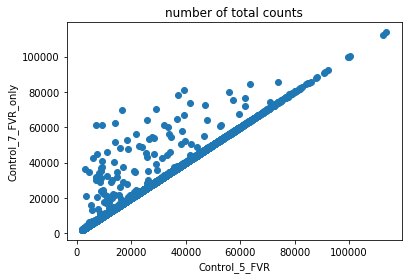

In [36]:
pl.scatter(x=adata_Control_5_FVR[np.in1d(adata_Control_5_FVR.obs_names, barcodes_dup)].obs['n_counts'], 
           y = adata_Control_7_FVR_only[np.in1d(adata_Control_7_FVR_only.obs_names, barcodes_dup)].obs['n_counts'])
pl.title('number of total counts')
pl.xlabel('Control_5_FVR')
pl.ylabel('Control_7_FVR_only')
pl.show()

We observe that most duplicated barcodes are have exactly the same number of total counts. However, some show a higher total count in `Control_7_FVR_only`, but not in `Control_5_FVR`. This can be explained by an expected random barcode overlap of 1-2% for any two unrelated samples - therefore, cells whose total counts is not exactly the same in both samples, are two different cells with the same barcode.
In order to mend the issue that `Control_7_FVR_only` also contains cells from `Control_5_FVR`, we subtract the raw count matrix of `Control_5_FVR` from the raw count matrix of `Control_7_FVR_only`.

In [37]:
adata_FVR_only_raw.obs_names

Index(['AAACCTGAGAAACCAT-1', 'AAACCTGAGAAACCGC-1', 'AAACCTGAGAAACCTA-1',
       'AAACCTGAGAAACGAG-1', 'AAACCTGAGAAACGCC-1', 'AAACCTGAGAAAGTGG-1',
       'AAACCTGAGAACAACT-1', 'AAACCTGAGAACAATC-1', 'AAACCTGAGAACTCGG-1',
       'AAACCTGAGAACTGTA-1',
       ...
       'TTTGTCATCTTGGGTA-1', 'TTTGTCATCTTGTACT-1', 'TTTGTCATCTTGTATC-1',
       'TTTGTCATCTTGTCAT-1', 'TTTGTCATCTTGTTTG-1', 'TTTGTCATCTTTACAC-1',
       'TTTGTCATCTTTACGT-1', 'TTTGTCATCTTTAGGG-1', 'TTTGTCATCTTTAGTC-1',
       'TTTGTCATCTTTCCTC-1'],
      dtype='object', length=737280)

In [38]:
len(np.intersect1d(adata_FVR_raw.obs_names,adata_FVR_only_raw.obs_names))

737280

In [39]:
adata_FVR_raw.n_obs

737280

In [40]:
print(adata_FVR_only_raw.X[:200,:200])

  (19, 7)	1.0
  (19, 20)	1.0
  (19, 25)	1.0
  (19, 29)	2.0
  (19, 39)	1.0
  (19, 51)	7.0
  (19, 52)	1.0
  (19, 62)	6.0
  (19, 63)	1.0
  (19, 122)	2.0
  (19, 131)	1.0
  (19, 152)	1.0
  (19, 163)	1.0
  (19, 188)	2.0
  (37, 131)	1.0
  (54, 62)	1.0
  (78, 62)	1.0
  (112, 62)	1.0
  (128, 62)	1.0
  (156, 186)	1.0
  (156, 188)	1.0
  (161, 62)	1.0
  (170, 153)	1.0
  (172, 7)	1.0
  (172, 51)	2.0
  (172, 62)	4.0
  (182, 52)	1.0
  (182, 62)	1.0
  (186, 62)	1.0


In [41]:
print(adata_FVR_raw.X[:200,:200])

  (19, 7)	1.0
  (19, 20)	1.0
  (19, 25)	1.0
  (19, 29)	2.0
  (19, 39)	1.0
  (19, 51)	7.0
  (19, 52)	1.0
  (19, 62)	6.0
  (19, 63)	1.0
  (19, 122)	2.0
  (19, 131)	1.0
  (19, 152)	1.0
  (19, 163)	1.0
  (19, 188)	2.0
  (37, 131)	1.0
  (78, 62)	1.0
  (112, 62)	1.0
  (128, 62)	1.0
  (156, 188)	1.0
  (161, 62)	1.0
  (170, 153)	1.0
  (172, 7)	1.0
  (172, 51)	2.0
  (172, 62)	4.0
  (182, 52)	1.0
  (182, 62)	1.0


In [42]:
adata_tmp = adata_FVR_only_raw.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [43]:
adata_tmp.X = adata_FVR_only_raw.X - adata_FVR_raw.X

In [44]:
adata_tmp

AnnData object with n_obs × n_vars = 737280 × 27998 

In [45]:
print(adata_tmp.X[:200,:200])

  (54, 62)	1.0
  (156, 186)	1.0
  (186, 62)	1.0


Check whether single values are lower than 0. 

In [46]:
print(adata_tmp.X<0)

  (13, 27876)	True
  (19, 15076)	True
  (23, 12264)	True
  (261, 227)	True
  (261, 7876)	True
  (618, 15524)	True
  (796, 14935)	True
  (913, 12343)	True
  (913, 15516)	True
  (913, 16497)	True
  (927, 15525)	True
  (962, 27908)	True
  (1122, 25106)	True
  (1150, 15524)	True
  (1150, 17128)	True
  (1197, 11509)	True
  (1197, 15503)	True
  (1304, 15525)	True
  (1314, 15525)	True
  (1368, 15551)	True
  (1387, 19164)	True
  (1490, 15520)	True
  (1576, 7422)	True
  (1576, 15524)	True
  (1891, 15525)	True
  :	:
  (735962, 27228)	True
  (735985, 15525)	True
  (736105, 7557)	True
  (736147, 22932)	True
  (736191, 15525)	True
  (736276, 15525)	True
  (736431, 18103)	True
  (736465, 15525)	True
  (736517, 15504)	True
  (736596, 470)	True
  (736596, 5645)	True
  (736596, 11830)	True
  (736596, 12297)	True
  (736596, 18104)	True
  (736596, 24968)	True
  (736596, 24976)	True
  (736596, 27914)	True
  (736608, 14817)	True
  (736648, 13207)	True
  (736648, 27911)	True
  (736738, 15525)	True
  (736822

In [47]:
adata_FVR_only_raw.X[13, 27876]

0.0

In [48]:
adata_FVR_raw.X[13, 27876]

1.0

CellRanger did not seem to aggregate all reads from the fastq files in the exact same way.

In [49]:
pd.value_counts(adata_tmp.X[adata_tmp.X<0].A1)

-1.0     18320
-2.0       408
-3.0        85
-4.0        38
-5.0        23
-6.0        14
-7.0         7
-8.0         7
-11.0        6
-9.0         4
-10.0        3
-15.0        3
-13.0        2
-19.0        2
-20.0        1
-12.0        1
-22.0        1
-57.0        1
-17.0        1
-18.0        1
-33.0        1
-40.0        1
-21.0        1
-60.0        1
dtype: int64

The difference is interesting, though we could not detect the source of it. We set all negative values to 0. 

In [50]:
adata_tmp.X[adata_tmp.X<0] = 0

Filter `Control_7_FVR_only` based on `countmin` value determined by CellRanger. 

In [51]:
adata_Control_7_FVR_only = cell_filter(adata_tmp,countmin)

filtered out 729007 cells that have less than 7298.0 counts
filtered out 732682 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
8511


Make `var_names` unique in all anndata objects.

In [52]:
adata_Control_1.var_names_make_unique()
adata_Control_2.var_names_make_unique() 
adata_Control_3_FVR.var_names_make_unique() 
adata_Control_4_FVR.var_names_make_unique()
adata_Mutant_1.var_names_make_unique() 
adata_Mutant_2.var_names_make_unique() 
adata_Mutant_3_FVR.var_names_make_unique() 
adata_Mutant_4_FVR.var_names_make_unique()
adata_Control_5_FVR.var_names_make_unique() 
adata_Control_6.var_names_make_unique() 
adata_Control_7_FVR_only.var_names_make_unique()

Concatenate all samples.

In [53]:
adata_all=adata_Control_1.concatenate([adata_Control_2, adata_Control_3_FVR, adata_Control_4_FVR,
                                       adata_Mutant_1, adata_Mutant_2, adata_Mutant_3_FVR, adata_Mutant_4_FVR,
                                       adata_Control_5_FVR, adata_Control_6, adata_Control_7_FVR_only],
                                       batch_key='sample',
                                       batch_categories=['Control_1', 'Control_2', 'Control_3_FVR', 'Control_4_FVR',
                                                         'Mutant_1', 'Mutant_2', 'Mutant_3_FVR', 'Mutant_4_FVR',
                                                         'Control_5_FVR', 'Control_6', 'Control_7_FVR_only'])

/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/anndata/base.py:1806: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat(out_obss)


In [54]:
sc.pp.filter_genes(adata_all, min_cells=20)

filtered out 11585 genes that are detected in less than 20 cells


In [55]:
adata_all=qc_metrics(adata_all)

59036


In [56]:
adata_all

AnnData object with n_obs × n_vars = 59036 × 16413 
    obs: 'n_counts', 'sample', 'percent_mito', 'percent_ribo', 'n_genes'
    var: 'n_cells', 'mean', 'frac_zeros'

In [57]:
adata_all.obs['sample'].value_counts()

Control_5_FVR         8906
Control_7_FVR_only    8511
Control_6             7574
Control_4_FVR         5338
Mutant_4_FVR          4608
Control_3_FVR         4416
Mutant_2              4167
Control_1             4047
Mutant_3_FVR          3978
Mutant_1              3949
Control_2             3542
Name: sample, dtype: int64

In [58]:
adata_all = adata_all[adata_all.obs['percent_mito'] < 0.1, :]

In [59]:
sc.write('./../data/new_filter_all.h5', adata_all)

# FOXA2 mice 

In [60]:
# filtered data (cell barcodes defined by Cellranger)
filename_data_CD_1 = './../filtered_data/CD_1/matrix.mtx'
filename_genes_CD_1 = './../filtered_data/CD_1/genes.tsv'
filename_barcodes_CD_1 = './../filtered_data/CD_1/barcodes.tsv'

adata_CD_1 = sc.read(filename_data_CD_1, cache=True).transpose()
adata_CD_1.var_names = np.genfromtxt(filename_genes_CD_1, dtype=str)[:, 1]
adata_CD_1.obs_names = np.genfromtxt(filename_barcodes_CD_1, dtype=str)

adata_CD_1.var_names_make_unique

# raw data (all barcodes)
filename_data_CD_1 = './../raw_data/CD_1/matrix.mtx'
filename_genes_CD_1 = './../raw_data/CD_1/genes.tsv'
filename_barcodes_CD_1 = './../raw_data/CD_1/barcodes.tsv'

adata_CD_1_raw = sc.read(filename_data_CD_1, cache=True).transpose()
adata_CD_1_raw.var_names = np.genfromtxt(filename_genes_CD_1, dtype=str)[:, 1]
adata_CD_1_raw.obs_names = np.genfromtxt(filename_barcodes_CD_1, dtype=str)

adata_CD_1_raw.var_names_make_unique


########


# filtered data (cell barcodes defined by Cellranger)
filename_data_CD_2 = './../filtered_data/CD_2/matrix.mtx'
filename_genes_CD_2 = './../filtered_data/CD_2/genes.tsv'
filename_barcodes_CD_2 = './../filtered_data/CD_2/barcodes.tsv'

adata_CD_2 = sc.read(filename_data_CD_2, cache=True).transpose()
adata_CD_2.var_names = np.genfromtxt(filename_genes_CD_2, dtype=str)[:, 1]
adata_CD_2.obs_names = np.genfromtxt(filename_barcodes_CD_2, dtype=str)

adata_CD_2.var_names_make_unique


# raw data (all barcodes)
filename_data_CD_2 = './../raw_data/CD_2/matrix.mtx'
filename_genes_CD_2 = './../raw_data/CD_2/genes.tsv'
filename_barcodes_CD_2 = './../raw_data/CD_2/barcodes.tsv'

adata_CD_2_raw = sc.read(filename_data_CD_2, cache=True).transpose()
adata_CD_2_raw.var_names = np.genfromtxt(filename_genes_CD_2, dtype=str)[:, 1]
adata_CD_2_raw.obs_names = np.genfromtxt(filename_barcodes_CD_2, dtype=str)


adata_CD_2_raw.var_names_make_unique()


############

# filtered data (cell barcodes defined by Cellranger)
filename_data_CD_3 = './../filtered_data/CD_3/matrix.mtx'
filename_genes_CD_3 = './../filtered_data/CD_3/genes.tsv'
filename_barcodes_CD_3 = './../filtered_data/CD_3/barcodes.tsv'

adata_CD_3 = sc.read(filename_data_CD_3, cache=True).transpose()
adata_CD_3.var_names = np.genfromtxt(filename_genes_CD_3, dtype=str)[:, 1]
adata_CD_3.obs_names = np.genfromtxt(filename_barcodes_CD_3, dtype=str)

adata_CD_3.var_names_make_unique()


# raw data (all barcodes)
filename_data_CD_3 = './../raw_data/CD_3/matrix.mtx'
filename_genes_CD_3 = './../raw_data/CD_3/genes.tsv'
filename_barcodes_CD_3 = './../raw_data/CD_3/barcodes.tsv'

adata_CD_3_raw = sc.read(filename_data_CD_3, cache=True).transpose()
adata_CD_3_raw.var_names = np.genfromtxt(filename_genes_CD_3, dtype=str)[:, 1]
adata_CD_3_raw.obs_names = np.genfromtxt(filename_barcodes_CD_3, dtype=str)
adata_CD_3_raw.var_names_make_unique()

... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... writing an h5ad cache file to speedup reading next time
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [61]:
### QC and cell filtering
adata_CD_1=qc_metrics(adata_CD_1)

# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_CD_1.obs['n_counts'])
adata_CD_1_filt= cell_filter(adata_CD_1_raw,countmin)
adata_CD_1_filt=qc_metrics(adata_CD_1_filt)

adata_CD_1_filt = adata_CD_1_filt[adata_CD_1_filt.obs['percent_mito'] < 0.1, :]
adata_CD_1_filt=qc_metrics(adata_CD_1_filt)

5083
filtered out 732197 cells that have less than 3906.0 counts
filtered out 731889 cells that have less than 1000 genes expressed
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
5407
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
5407
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
5407


In [62]:
### QC and cell filtering
adata_CD_2=qc_metrics(adata_CD_2)

# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_CD_2.obs['n_counts'])
adata_CD_2_filt= cell_filter(adata_CD_2_raw,countmin)
adata_CD_2_filt=qc_metrics(adata_CD_2_filt)

adata_CD_2_filt = adata_CD_2_filt[adata_CD_2_filt.obs['percent_mito'] < 0.1, :]
adata_CD_2_filt=qc_metrics(adata_CD_2_filt)

4824
filtered out 732456 cells that have less than 5008.0 counts
filtered out 731994 cells that have less than 1000 genes expressed
5298
5298
5298


In [63]:
### QC and cell filtering
adata_CD_3=qc_metrics(adata_CD_3)

# count threshold from Cellranger filtering (minimal total count)
countmin = min(adata_CD_3.obs['n_counts'])
adata_CD_3_filt= cell_filter(adata_CD_3_raw,countmin)
adata_CD_3_filt=qc_metrics(adata_CD_3_filt)

adata_CD_3_filt = adata_CD_3_filt[adata_CD_3_filt.obs['percent_mito'] < 0.1, :]
adata_CD_3_filt=qc_metrics(adata_CD_3_filt)

4731
filtered out 732549 cells that have less than 4502.0 counts
filtered out 732022 cells that have less than 1000 genes expressed
5271
5271
5271


In [64]:
adata_CD_1_filt.var_names_make_unique()
adata_CD_2_filt.var_names_make_unique()
adata_CD_3_filt.var_names_make_unique()

In [65]:
adata_all=adata_CD_1_filt.concatenate([adata_CD_2_filt, adata_CD_3_filt],
                                       batch_key='sample',
                                       batch_categories=['CD_1', 'CD_2', 'CD_3'])

In [66]:
sc.pp.filter_genes(adata_all, min_cells=20)
adata_all=qc_metrics(adata_all)

filtered out 13033 genes that are detected in less than 20 cells
15976


In [67]:
sc.write('./../data/control_only_new_filter_all_vers_1_4.h5',adata_all)